OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.



Tester les modèles suivants : **regression linéaire (avec différentes régularisation : Ridge, Lasso, Elastic), Random Forest, XGboost**
Penser à comparer les performances des différents modèles : utiliser la **MAE** ( Mean Absolute Error)
Penser également à optimiser les hyper paramètres de chaque modèle via **GridSearch**


Evaluate :

https://cloud.google.com/automl-tables/docs/evaluate?hl=fr


KFOLD

Entrée : données X (dimension nxp), étiquettes y (dimension n), nombre de folds k

Couper [0, 1, ..., n-1] en k parties de taille (n/k). (La dernière partie sera un peu plus petite si n n'est pas un multiple de k)

for i=0 to (k-1):
    Former le jeu de test (X_test, y_test) en restreignant X et y aux indices contenus dans la i-ième partie.
    Former le jeu d'entraînement (X_train, y_train) en restreignant X et y aux autres indices.
    Entraîner l'algorithme sur le jeu d'entraînement
    Utiliser le modèle ainsi obtenu pour prédire sur le jeu de test
        Calculer l'erreur du modèle en comparant les étiquettes prédites aux vraies étiquettes contenues dans y_test

Sortie : la valeur moyenne des erreurs calculées sur les k folds.

In [59]:
# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire

### Introduction

#### Importing libraries

In [60]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time, strftime, gmtime
import pickle

import warnings
warnings.filterwarnings(action="ignore")

from evaluate import *

from os import listdir
from os.path import isfile, join

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [61]:
# Heure démarrage
t0 = time()

seed = 1
print("Seed value: ", seed)

Seed value:  1


#### Loading dataset

In [62]:
#train_CO2_file = "./dataset/cleaned/CO2/train_CO2.csv"
#test_CO2_file = "./dataset/cleaned/CO2/test_CO2.csv"

#train_CO2_file = r"C:\Users\oumei\Documents\OC_projets\P4\P4_Data_Science_OpenClassrooms\model\test\CO2\train_CO2.csv"
#test_CO2_file = r"C:\Users\oumei\Documents\OC_projets\P4\P4_Data_Science_OpenClassrooms\model\test\CO2\test_CO2.csv"

#train = pd.read_csv(train_CO2_file, sep=",")
#test = pd.read_csv(test_CO2_file, sep=",")

target = "Log-TotalGHGEmissions"
target_dir = "ratio"

In [63]:
train_CO2_file_TEST = r"C:\Users\oumei\Documents\OC_projets\P4\P4_Data_Science_OpenClassrooms\model\test\ratio\train_ratio.csv"
test_CO2_file_TEST = r"C:\Users\oumei\Documents\OC_projets\P4\P4_Data_Science_OpenClassrooms\model\test\ratio\test_ratio.csv"
train_TEST = pd.read_csv(train_CO2_file_TEST, sep=",")
test_TEST = pd.read_csv(test_CO2_file_TEST, sep=",")

In [64]:
display(train_TEST)

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Ratio_Electricity,Ratio_Gas,Ratio_Steam+Gas,YearBuilt,Log-TotalGHGEmissions
0,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.52969,0.61094,0.73312,-0.92353,-0.43924,-0.70149,-0.28263,0.70152,1927,5.52537
1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.71267,0.61187,0.67086,1.07289,2.15381,-1.29163,1.33971,1.29165,1996,5.69326
2,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,3.28749,3.19506,3.26082,-0.92353,-0.43924,-0.19724,-0.86232,0.19727,1969,7.64505
3,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.64022,0.14657,0.73838,-0.92353,-0.43924,-0.46528,0.51035,0.46531,1999,5.71311
4,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.70363,0.79139,0.90994,-0.92353,-0.43924,-0.58544,-0.71158,0.58546,1926,5.40497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,-0.34944,-0.30107,-0.14332,0.84158,-0.43924,-0.38624,0.43101,0.38626,2015,3.37005
2198,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.91353,-0.91514,-0.75219,0.86689,2.07101,-1.24257,1.29048,1.24259,2015,4.33886
2199,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.15191,0.12406,0.47854,-0.92353,-0.43924,-0.34143,0.38604,0.34145,2015,4.02106
2200,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,2.03748,2.17512,2.26588,-0.92353,-0.43924,-0.74142,0.78750,0.74144,2015,6.15039


#### Separating features and target vectors

In [65]:
#features_for_prediction = ["Log-Electricity(kBtu)", "Log-TotalEnergy(kBtu)", "Log-NaturalGas(kBtu)", "Log-SteamUse(kBtu)"]
features_for_prediction = train_TEST.columns.tolist()[:-1]
features_for_prediction

['Neighborhood_Ballard',
 'Neighborhood_Central',
 'Neighborhood_Delridge',
 'Neighborhood_Downtown',
 'Neighborhood_East',
 'Neighborhood_Greater duwamish',
 'Neighborhood_Lake union',
 'Neighborhood_Magnolia / queen anne',
 'Neighborhood_North',
 'Neighborhood_Northeast',
 'Neighborhood_Northwest',
 'Neighborhood_Southeast',
 'Neighborhood_Southwest',
 'BuildingType_Campus',
 'BuildingType_Multifamily hr (10+)',
 'BuildingType_Multifamily lr (1-4)',
 'BuildingType_Multifamily mr (5-9)',
 'BuildingType_Nonresidential',
 'BuildingType_Nonresidential cos',
 'BuildingType_Sps-district k-12',
 'PrimaryPropertyType_Distribution center',
 'PrimaryPropertyType_High-rise multifamily',
 'PrimaryPropertyType_Hospital',
 'PrimaryPropertyType_Hotel',
 'PrimaryPropertyType_K-12 school',
 'PrimaryPropertyType_Laboratory',
 'PrimaryPropertyType_Large office',
 'PrimaryPropertyType_Low-rise multifamily',
 'PrimaryPropertyType_Medical office',
 'PrimaryPropertyType_Mid-rise multifamily',
 'PrimaryProp

In [66]:
#X_train = train_CO2.iloc[:, :-1] # all rows, 51 columns (not last five)
#X_test = test_CO2.iloc[:, :-1]

X_train = train_TEST[features_for_prediction]
X_test = test_TEST[features_for_prediction]

y_train = train_TEST[target]
y_test = test_TEST[target]

In [67]:
X_train

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Ratio_Electricity,Ratio_Gas,Ratio_Steam+Gas,YearBuilt
0,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.73984,0.52969,0.61094,0.73312,-0.92353,-0.43924,-0.70149,-0.28263,0.70152,1927
1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.60217,0.71267,0.61187,0.67086,1.07289,2.15381,-1.29163,1.33971,1.29165,1996
2,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,3.75677,3.28749,3.19506,3.26082,-0.92353,-0.43924,-0.19724,-0.86232,0.19727,1969
3,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.78209,0.64022,0.14657,0.73838,-0.92353,-0.43924,-0.46528,0.51035,0.46531,1999
4,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.10739,0.70363,0.79139,0.90994,-0.92353,-0.43924,-0.58544,-0.71158,0.58546,1926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.09647,-0.34944,-0.30107,-0.14332,0.84158,-0.43924,-0.38624,0.43101,0.38626,2015
2198,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-0.28731,-0.91353,-0.91514,-0.75219,0.86689,2.07101,-1.24257,1.29048,1.24259,2015
2199,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.90482,0.15191,0.12406,0.47854,-0.92353,-0.43924,-0.34143,0.38604,0.34145,2015
2200,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.90482,2.03748,2.17512,2.26588,-0.92353,-0.43924,-0.74142,0.78750,0.74144,2015


In [68]:
y_train

0      5.52537
1      5.69326
2      7.64505
3      5.71311
4      5.40497
         ...  
2197   3.37005
2198   4.33886
2199   4.02106
2200   6.15039
2201   2.98971
Name: Log-TotalGHGEmissions, Length: 2202, dtype: float64

In [69]:
# predict : Electricity
# train / test
# standardisation = retirer la moyen et div par ecart type (scaling : les var qn sur emem echelle
# var categ : encoding (one hot encoder)

# la fin Feature engineriing

# 2) entrainer le smodels
# perf
# temps de calcul
# graph pour montrer la perf de chaque modele(barplot)
# obj : finir exploration / finir feature engineering
# obj un premier noteboook propre (try max)

In [70]:
X_test

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Ratio_Electricity,Ratio_Gas,Ratio_Steam+Gas,YearBuilt
0,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.45252,0.10553,0.17092,0.30194,-0.92353,-0.43924,-1.21424,0.05142,1.21426,1926
1,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,2.39251,1.32419,0.91168,1.12591,1.38569,-0.43924,-1.32052,1.36871,1.32054,1980
2,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.60217,0.45634,0.53485,0.63483,-0.92353,-0.43924,-0.91578,0.96250,0.91580,1926
3,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.60217,1.16595,1.10933,1.22150,-0.92353,-0.43924,-1.29268,0.12617,1.29270,1969
4,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.28860,0.17320,0.24112,0.37073,-0.92353,-0.43924,-1.96892,1.08672,1.96894,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.90482,1.55316,1.34000,1.39331,1.52798,-0.43924,-0.97437,1.02130,0.97440,2015
941,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.67516,0.49796,0.44669,0.59068,0.94481,1.78009,0.97855,-0.93876,-0.97851,2015
942,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,...,0.67516,2.10763,1.90817,1.36725,1.47876,3.04485,-0.50014,0.54533,0.50016,2015
943,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.90482,1.52123,1.24045,1.49036,1.29868,-0.43924,-0.65037,0.69612,0.65040,2015


In [71]:
print("The shape of the training matrix :", X_train.shape, "and this is the shape of the target vector :", y_train.shape)
print("The shape of the test matrix :", X_test.shape, "and this is the shape of the target vector :", y_test.shape)

The shape of the training matrix : (2202, 53) and this is the shape of the target vector : (2202,)
The shape of the test matrix : (945, 53) and this is the shape of the target vector : (945,)


## Trying linear models and ensemble methods

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

### 0) Before starting : CV, Baselines

#### Evaluation metric

In [73]:
# Setting evaluation metric for regression
scoring = 'r2'

#### Cross-Validation

In [74]:
# Define the cross-validation generator
#cv_inner = KFold(n_splits=10, # number of folds (default=5)
                 #shuffle=True, # shuffle the data before splitting into batche
                 #random_state=seed) # seeding the random number generator for shuffling

# define model evaluation method
#cv = RepeatedKFold(n_splits=10,
 #                  n_repeats=3,
  #                 random_state=seed)

# step-1: create a cross-validation scheme / # create a KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=seed)

#### Baseline : Dummy Regressor

Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.38799,1.92650,1.14600,1.04579,-0.00004


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Dummy Regressor,1.38799,1.92650,1.14600,1.04579,-0.00004


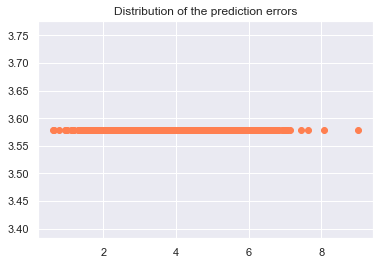

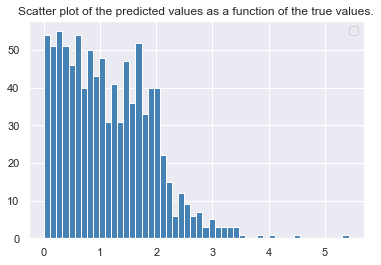

In [75]:
from sklearn import dummy

# 0) We create a dummy regressor model that always predicts the mean value of the feature to predict
dum = dummy.DummyRegressor(strategy='mean')

# 1) Training Dummy Regression
dum.fit(X_train, y_train)

# 2) Prediction on the testing set
y_pred_dum = dum.predict(X_test)

# 3) Evaluate
evaluate_regression("Dummy Regressor", results, y_test, y_pred_dum)

#### Baseline : Linear Regression

R2 : 0.8927706499184548
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277


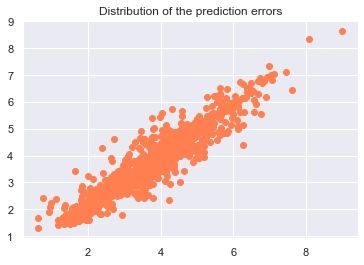

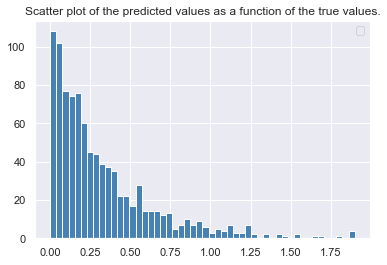

In [76]:
from sklearn import linear_model

# 0) We create a linear regression model
lr = linear_model.LinearRegression()

# 1) Training Linear Regression and Evaluating
reg = lr.fit(X_train, y_train)
y_pred_lr = reg.predict(X_test)

prediction_score = lr.score(X_test, y_test)
print('R2 : {}'.format(prediction_score))

results = evaluate_regression("Linear Regression", results, y_test, y_pred_lr)

##### Baseline Linear Regression with Cross Valisation

In [77]:
lr_scores = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='r2', cv=folds, n_jobs=-1)
lr_mean_cv_score = np.mean(lr_scores)
print("Linear Regression CV :", lr_mean_cv_score)

results_cv = summary_results_cv("Linear Regression CV", lr_mean_cv_score, results_cv)

Linear Regression CV : 0.8832808527518253
Results Cross-Validated


,Model,Mean CV R²
0,Linear Regression CV,0.88328


#### Baseline score and scoring metric for evaluation

In [78]:
baseline_error = mean_squared_error(y_test, y_pred_lr)
print("Baseline error = MSE from Linear Regression :", baseline_error)

Baseline error = MSE from Linear Regression : 0.2065691247273573


### 1) Linear Model : Ridge Regression


#### 1.1) Trying Ridge Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [79]:
a, b = -2, 2
n_alphas = 50 # hyperparametre alpha
alphas = np.logspace(a, b, n_alphas)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    coefs.append(ridge.coef_)
    errors.append(np.mean((y_pred_ridge - y_test) ** 2))
    #print("HERE :", np.mean(( - y_test) ** 2), "MSE :", mean_squared_error(y_test, ridge.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for Ridge Regression : 0.2059959350630304
Best alpha for that minimal MSE :  1.325711365590108


(0.00630957344480193,
 158.48931924611142,
 0.20367583842479167,
 0.2547179644660439)

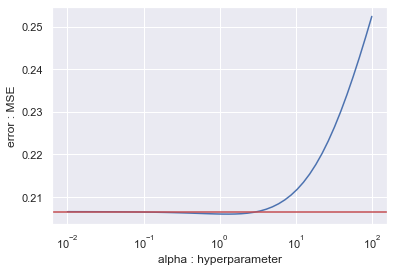

In [80]:
# recupere l'erreur min
print("Minimum Mean Squared Error for Ridge Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors)
# specifying horizontal line type
plt.axhline(y=baseline_error, color='r', linestyle='-')

ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(0.00630957344480193,
 158.48931924611142,
 -1.4902914706420327,
 1.5468531898264528)

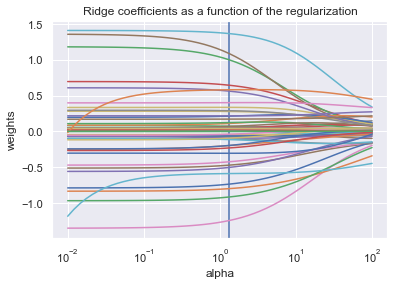

In [81]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  1.325711365590108
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.45387,0.20600,0.31980,0.20922,0.89307
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277


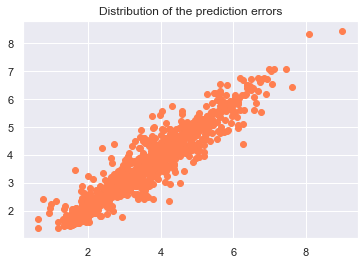

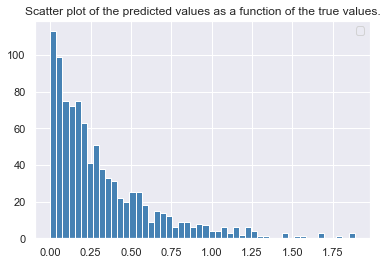

In [82]:
print("Getting y_pred for the best alpha : ", min_alpha)
ridge.set_params(alpha=min_alpha)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# 3) Evaluate
results = evaluate_regression("Ridge manually", results, y_test, y_pred_ridge)

##### 2.2) Optimization of hyperparameters

In [83]:
a, b = -2, 2
n_alphas = 50 # hyperparametre alpha

# define the model/ estimator
model = linear_model.Ridge()
params = {"alpha": np.logspace(a, b, n_alphas)} # alpha > 0

# define the grid search
Ridge_grid = GridSearchCV(
    model, params, scoring=scoring,
    cv=folds,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Ridge_grid.fit(X_train.values, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7.90604321e-02,
       9.54095476e-02, 1.15139540e-01, 1.38949549e-01, 1.676832...
       1.93069773e+00, 2.32995181e+00, 2.81176870e+00, 3.39322177e+00,
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02])},
             return_train_score=True, scoring='r2', verbose=1)

Best estimator : Ridge(alpha=0.7543120063354615)
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,Ridge manually,0.45387,0.20600,0.31980,0.20922,0.89307
0,Ridge GridSearchCV,0.45395,0.20607,0.31958,0.20753,0.89303
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277


Results Cross-Validated


,Model,Mean CV R²
0,Ridge Regression CV,0.88441
0,Linear Regression CV,0.88328


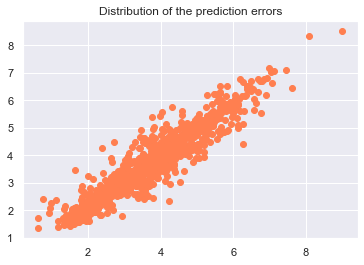

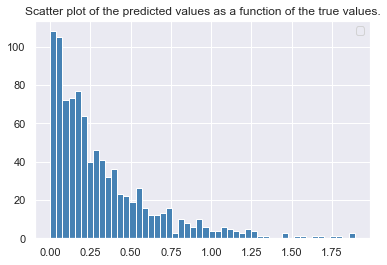

In [84]:
# best estimator
print("Best estimator :", Ridge_grid.best_estimator_)

# best model
best_model = Ridge_grid.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_ridge = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("Ridge GridSearchCV", results, y_test, y_pred_ridge)

results_cv = summary_results_cv("Ridge Regression CV", Ridge_grid.best_score_, results_cv)

#### 2) Linear Model : LASSO (Least Absolute Shrinkage and Selection Operator

##### 2.1) Trying LASSO Regression / Manual optimisation hyperparameter

##### 1. Searching for the best hyperparameter alpha

In [85]:
n_alphas = 50  # hyperparametre alpha
a, b = -5, -2
alphas = np.logspace(a, b, n_alphas)

lasso = linear_model.Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    coefs.append(lasso.coef_)
    errors.append(np.mean((y_pred_lasso - y_test) ** 2))
    #print("HERE :", np.mean((lasso.predict(X_test) - y_test) ** 2), "MSE :", mean_squared_error(y_test, lasso.predict(X_test)))

##### 2. Visualizing optimisation of alpha

Minimum Mean Squared Error for LASSO Regression : 0.20566430872173566
Best alpha for that minimal MSE :  0.0005963623316594642


(7.079457843841373e-06,
 0.01412537544622754,
 0.20312710747572146,
 0.25894553488803407)

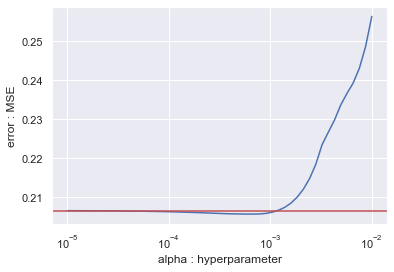

In [86]:
# recupere l'erreur min
print("Minimum Mean Squared Error for LASSO Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors)
plt.axhline(y=baseline_error, color='r', linestyle='-')
ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

(7.079457843841373e-06,
 0.01412537544622754,
 -1.4338201617613306,
 1.633390400861909)

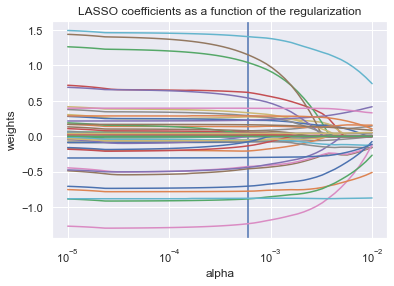

In [87]:
# chemin de régularisation
ax = plt.gca()

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('LASSO coefficients as a function of the regularization')
plt.axis('tight')

##### 3. Using best value of the hyperparameter alpha

Getting y_pred for the best alpha :  0.0005963623316594642
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,0.45350,0.20566,0.31949,0.20739,0.89324
0,Ridge manually,0.45387,0.20600,0.31980,0.20922,0.89307
0,Ridge GridSearchCV,0.45395,0.20607,0.31958,0.20753,0.89303
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277


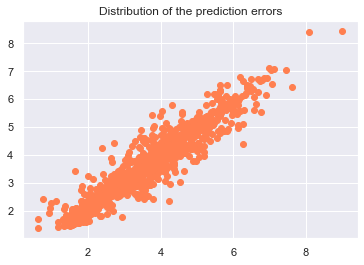

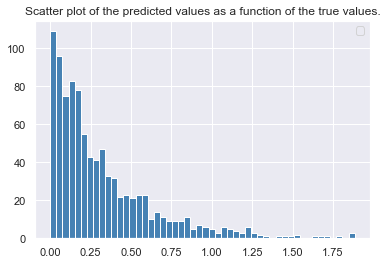

In [88]:
print("Getting y_pred for the best alpha : ", min_alpha)
lasso.set_params(alpha=min_alpha)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# 3) Evaluate
results = evaluate_regression("LASSO manually", results, y_test, y_pred_lasso)

##### 3.2) Optimization of hyperparameters

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best estimator : Lasso(alpha=0.0004094915062380423)
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,0.45350,0.20566,0.31949,0.20739,0.89324
0,LASSO GridSearchCV,0.45358,0.20573,0.31932,0.20729,0.89320
0,Ridge manually,0.45387,0.20600,0.31980,0.20922,0.89307
0,Ridge GridSearchCV,0.45395,0.20607,0.31958,0.20753,0.89303
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277


Results Cross-Validated


,Model,Mean CV R²
0,LASSO Regression CV,0.88471
0,Ridge Regression CV,0.88441
0,Linear Regression CV,0.88328


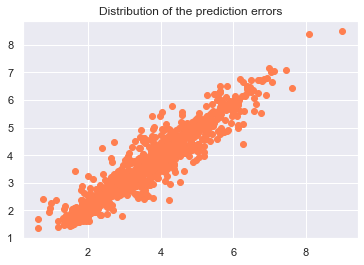

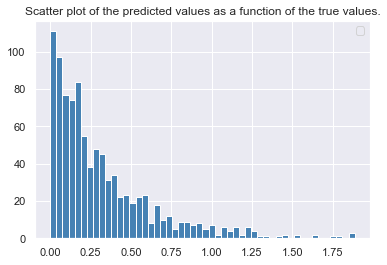

In [89]:
n_alphas = 50
a, b = -4, -2
params = {"alpha": np.logspace(a, b, n_alphas)}

# define the model/ estimator
model = linear_model.Lasso()

# define the grid search
Lasso_grid = GridSearchCV(
    model, params, scoring=scoring,
    cv=folds,
    n_jobs=-1,
    return_train_score=True,
    verbose=1)

#fit the grid search
Lasso_grid.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", Lasso_grid.best_estimator_)

# best model
best_model = Lasso_grid.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_lasso = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("LASSO GridSearchCV", results, y_test, y_pred_lasso)

results_cv = summary_results_cv("LASSO Regression CV", Lasso_grid.best_score_, results_cv)

#### 3) Linear Model : Elastic Net

##### 3.1) Preparation of the grid parameters

In [90]:
n = 100
# or : l1_ratio = [i / n for i in range(n)]
l1_ratio = np.arange(start=0, stop=1, step= 1/n)

a, b , n_alphas = -5, 5, 1000

param_grid_elastic = [{
    "alpha": np.logspace(a, b, n_alphas), # penalty intensity (5 values between 10⁻³ and 10¹)
    "l1_ratio": l1_ratio # mixing parameter for l1 and l2 penalties
}]

##### 3.2) Optimization of hyperparameters : RandomSearchCV

R2 : 0.8931787582235468 RMSE : 0.4536330404143627 Best params : {'l1_ratio': 0.77, 'alpha': 0.00041842885079015847}
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,0.45350,0.20566,0.31949,0.20739,0.89324
0,LASSO GridSearchCV,0.45358,0.20573,0.31932,0.20729,0.89320
0,Elastic Net RandomSearchCV,0.45363,0.20578,0.31939,0.20852,0.89318
0,Ridge manually,0.45387,0.20600,0.31980,0.20922,0.89307
0,Ridge GridSearchCV,0.45395,0.20607,0.31958,0.20753,0.89303
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277


Results Cross-Validated


,Model,Mean CV R²
0,LASSO Regression CV,0.88471
0,Elastic Net RandomSearchCV,0.88468
0,Ridge Regression CV,0.88441
0,Linear Regression CV,0.88328


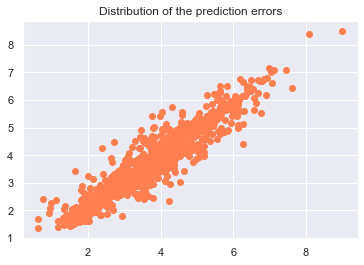

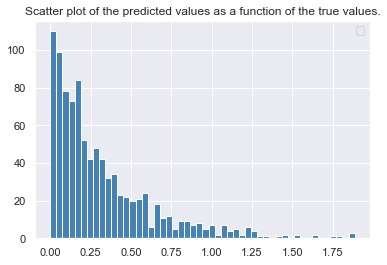

In [91]:
regressor = linear_model.ElasticNet()

# Intenciation of RandomizedSearchCV object
Elastic_RandomSearch_grid = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_grid_elastic, # choice of hyper-parameters to test
    scoring=scoring, # scoring method for regression
    cv=folds, # cross-validation generator
    n_jobs=-1, # use all available cores (parallelization)
    return_train_score=True, # to avoid a DeprecationWarning
    verbose=0,
    random_state=seed,

    n_iter=100, # number of combinations of hyper-parameters to try
    refit=True
)

# Call the RanddomizedSearch with Cross Validation using the chosen regressor
Elastic_RandomSearch_grid.fit(X_train, y_train)

# Results
y_pred_elastic = Elastic_RandomSearch_grid.predict(X_test)
R2_score = Elastic_RandomSearch_grid.score(X_test, y_test)
RMSE_score = np.sqrt(mean_squared_error(y_test, y_pred_elastic))

print("R2 :", R2_score, "RMSE :", RMSE_score, "Best params :", Elastic_RandomSearch_grid.best_params_)
results = evaluate_regression("Elastic Net RandomSearchCV", results, y_test, y_pred_elastic)

results_cv = summary_results_cv("Elastic Net RandomSearchCV", Elastic_RandomSearch_grid.best_score_, results_cv)

##### 3.3) Optimization of hyperparameters : GridSearchCV

In [92]:
n = 10
# or : l1_ratio = [i / n for i in range(n)]
l1_ratio = np.arange(start=0, stop=1, step= 1/n)

a, b , n_alphas = -4, 2, 50

param_grid_elastic = [{
    "alpha": np.logspace(a, b, n_alphas), # penalty intensity (5 values between 10⁻³ and 10¹)
    "l1_ratio": l1_ratio # mixing parameter for l1 and l2 penalties
}]

R2 : 0.8931941522961176 RMSE : 0.205753279854594
Best params : {'alpha': 0.00040949150623804275, 'l1_ratio': 0.9}
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,0.45350,0.20566,0.31949,0.20739,0.89324
0,LASSO GridSearchCV,0.45358,0.20573,0.31932,0.20729,0.89320
0,Elastic Net GridSearchCV,0.45360,0.20575,0.31933,0.20945,0.89319
0,Elastic Net RandomSearchCV,0.45363,0.20578,0.31939,0.20852,0.89318
0,Ridge manually,0.45387,0.20600,0.31980,0.20922,0.89307
0,Ridge GridSearchCV,0.45395,0.20607,0.31958,0.20753,0.89303
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277


Results Cross-Validated


,Model,Mean CV R²
0,LASSO Regression CV,0.88471
0,Elastic Net GridSearchCV,0.88470
0,Elastic Net RandomSearchCV,0.88468
0,Ridge Regression CV,0.88441
0,Linear Regression CV,0.88328


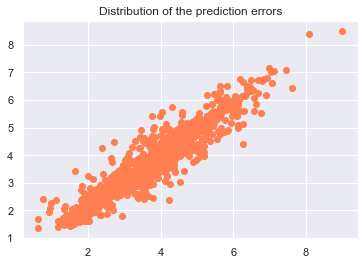

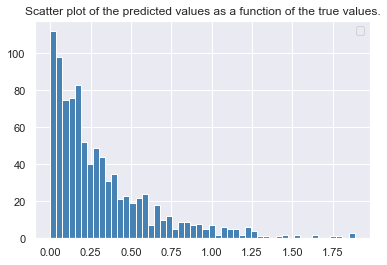

In [93]:
Elastic_GridSearch_grid= GridSearchCV(estimator=regressor,
                          param_grid=param_grid_elastic,
                          scoring=scoring,
                          cv=folds,
                          verbose=0,
                          n_jobs=-1,
                          return_train_score=True)

Elastic_GridSearch_grid.fit(X_train, y_train)

# Results
y_pred_elastic = Elastic_GridSearch_grid.predict(X_test)
R2_score = Elastic_GridSearch_grid.score(X_test, y_test)
MSE_score = mean_squared_error(y_test, y_pred_elastic)

print("R2 :", R2_score, "RMSE :", MSE_score)
print( "Best params :", Elastic_GridSearch_grid.best_params_)
#print("Train score :", Elastic_GridSearch_grid.cv_results_["mean_train_score"])

results = evaluate_regression("Elastic Net GridSearchCV", results, y_test, y_pred_elastic)

results_cv = summary_results_cv("Elastic Net GridSearchCV", Elastic_GridSearch_grid.best_score_, results_cv)

### 2) Ensemble learning methods

#### 1) Parallelized Implementation : Random Forest

In [94]:
# Grid of research for Random Forest
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()

# Create space of candidate values for hyperparameters

n_estimators = [10, 50, 100, 300, 500] #nombre d'arbres de décision
#max_depth = [5,10,15,20] #     "max_depth": max_depth,

min_samples_split = [2, 5, 10, 20, 50] # 2 is the default parameter

min_samples_leaf =  [1, 3, 5, 10], #nombre de feuilles minimales dans un noeud # default = 1
max_features = ['auto', 'sqrt'] #nombre de features observées pour chaque arbre # default = 1, <1 more random
max_leaf_nodes = [2, 3, 4, 5, 6, 7] # default = None     "max_leaf_nodes": max_leaf_nodes,

#grid = {"min_samples_split": min_samples_split,
#"min_samples_leaf": min_samples_leaf,
#"max_features": max_features}

'''

'''
param_grid_forest = [{
    "n_estimators": n_estimators
}]

# Intenciation of RandomizedSearchCV object
RandomForest_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=seed),
                                 param_grid=param_grid_forest,
                                 scoring=scoring,
                                 verbose=0,
                                 cv=folds,
                                 n_jobs=-1,
                                 return_train_score=True) # to avoid a DeprecationWarning                                  )

#RandomizedSearchCV(
 #   estimator=regressor,
  #  param_distributions=param_grid_forest, # choice of hyper-parameters to test
   # scoring=scoring, # scoring method for regression
    #cv=folds, # cross-validation generator
    #n_jobs=-1, # use all available cores (parallelization)
    #return_train_score=True, # to avoid a DeprecationWarning
    #n_iter=100,
# random_state=seed)

# Call the RanddomizedSearch with Cross Validation using the chosen regressor
RandomForest_grid.fit(X_train, y_train)
# Results
y_pred_rfr = RandomForest_grid.predict(X_test)
R2_score = RandomForest_grid.score(X_test, y_test)
MSE_score = mean_squared_error(y_test, y_pred_rfr)

print("R2 :", R2_score, "MSE :", MSE_score, "Best params :", RandomForest_grid.best_params_)

R2 : 0.8827393826651921 MSE : 0.22589359228066094 Best params : {'n_estimators': 300}


In [95]:
coefficients = abs(RandomForest_grid.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X_train.columns, columns = ['Feature']),
                             pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

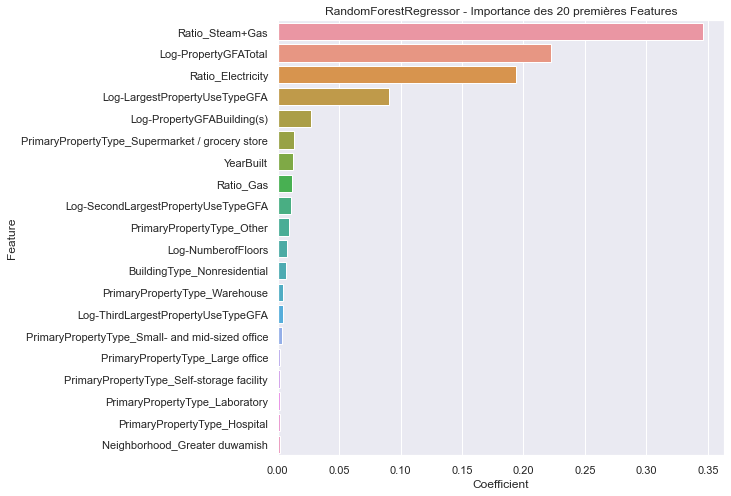

In [96]:
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Feature'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,LASSO manually,0.45350,0.20566,0.31949,0.20739,0.89324
0,LASSO GridSearchCV,0.45358,0.20573,0.31932,0.20729,0.89320
0,Elastic Net GridSearchCV,0.45360,0.20575,0.31933,0.20945,0.89319
0,Elastic Net RandomSearchCV,0.45363,0.20578,0.31939,0.20852,0.89318
0,Ridge manually,0.45387,0.20600,0.31980,0.20922,0.89307
0,Ridge GridSearchCV,0.45395,0.20607,0.31958,0.20753,0.89303
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277
0,Random Forest GridSearchCV,0.47528,0.22589,0.33330,0.21840,0.88274


Results Cross-Validated


,Model,Mean CV R²
0,LASSO Regression CV,0.88471
0,Elastic Net GridSearchCV,0.88470
0,Elastic Net RandomSearchCV,0.88468
0,Ridge Regression CV,0.88441
0,Linear Regression CV,0.88328
0,Random Forest CV,0.86913


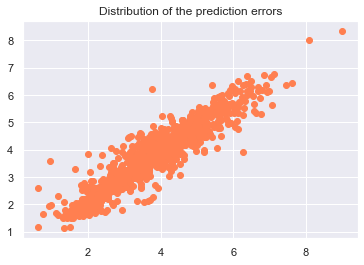

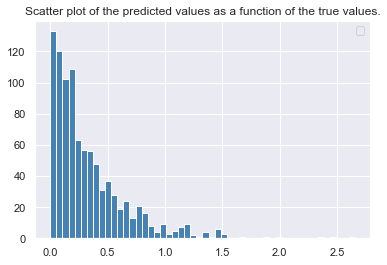

In [97]:
results = evaluate_regression("Random Forest GridSearchCV", results, y_test, y_pred_rfr)

results_cv = summary_results_cv("Random Forest CV", RandomForest_grid.best_score_, results_cv)

#### 2) Sequential method : XGBoost

GridSearchCV XGBoost Regressor
Best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Prediction for :  Log-TotalGHGEmissions


,Model,RMSE,MSE,MAE,Median Absolute Error,R² = 1 - RSE
0,XGBoost GridSearchCV,0.42791,0.18311,0.29781,0.19941,0.90495
0,LASSO manually,0.45350,0.20566,0.31949,0.20739,0.89324
0,LASSO GridSearchCV,0.45358,0.20573,0.31932,0.20729,0.89320
0,Elastic Net GridSearchCV,0.45360,0.20575,0.31933,0.20945,0.89319
0,Elastic Net RandomSearchCV,0.45363,0.20578,0.31939,0.20852,0.89318
0,Ridge manually,0.45387,0.20600,0.31980,0.20922,0.89307
0,Ridge GridSearchCV,0.45395,0.20607,0.31958,0.20753,0.89303
0,Linear Regression,0.45450,0.20657,0.31944,0.20846,0.89277
0,Random Forest GridSearchCV,0.47528,0.22589,0.33330,0.21840,0.88274


Results Cross-Validated


,Model,Mean CV R²
0,XGBoost CV,0.88909
0,LASSO Regression CV,0.88471
0,Elastic Net GridSearchCV,0.88470
0,Elastic Net RandomSearchCV,0.88468
0,Ridge Regression CV,0.88441
0,Linear Regression CV,0.88328
0,Random Forest CV,0.86913


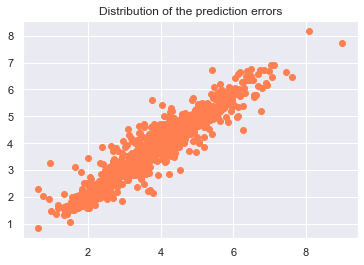

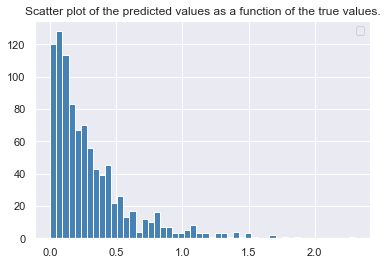

In [98]:
print("GridSearchCV XGBoost Regressor")

from xgboost import XGBRegressor
"""
param_grid_xgb = [{"learning_rate": (0.05, 0.10, 0.15),
                   "max_depth": [ 3, 4, 5, 6, 8],
                   "min_child_weight": [ 1, 3, 5, 7],
                   "gamma":[ 0.0, 0.1, 0.2],
                   "colsample_bytree":[ 0.3, 0.4],}]

XGBoost_grid = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_grid_xgb,
    cv=folds, scoring=scoring, verbose=0, n_jobs=-1, n_iter=100, random_state=seed)
"""
parameters = {
    'n_estimators' : [100,500,1000,2000],
    "learning_rate": (0.05, 0.10, 0.15),
    "gamma":[ 0.0, 0.1, 0.2]
}
XGBoost_grid = GridSearchCV(XGBRegressor(n_jobs=-1),
                              param_grid=parameters,
                              scoring=scoring,
                              cv=folds,
                              verbose=0,
                              n_jobs=-1)

#fit the grid search
XGBoost_grid.fit(X_train.values, y_train)

# best estimator
print("Best estimator :", XGBoost_grid.best_estimator_)

# best model
best_model = XGBoost_grid.best_estimator_
best_model.fit(X_train.values, y_train)

y_pred_xgbr = best_model.predict(X_test.values)

# 3) Evaluate
results = evaluate_regression("XGBoost GridSearchCV", results, y_test, y_pred_xgbr)
results_cv = summary_results_cv("XGBoost CV", XGBoost_grid.best_score_, results_cv)

### Evaluation

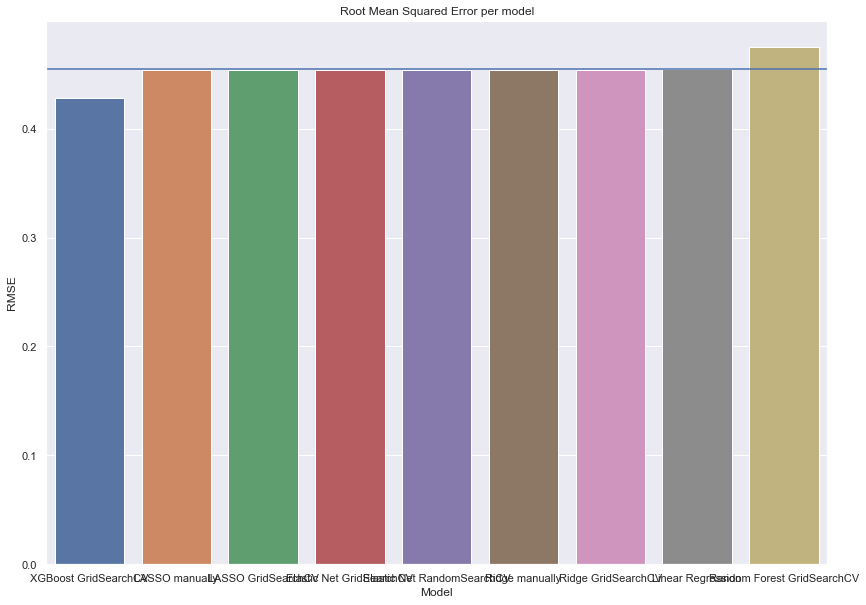

In [99]:
display_barplot_errors(results, baseline_model="Linear Regression", title="Root Mean Squared Error per model", metric="RMSE")

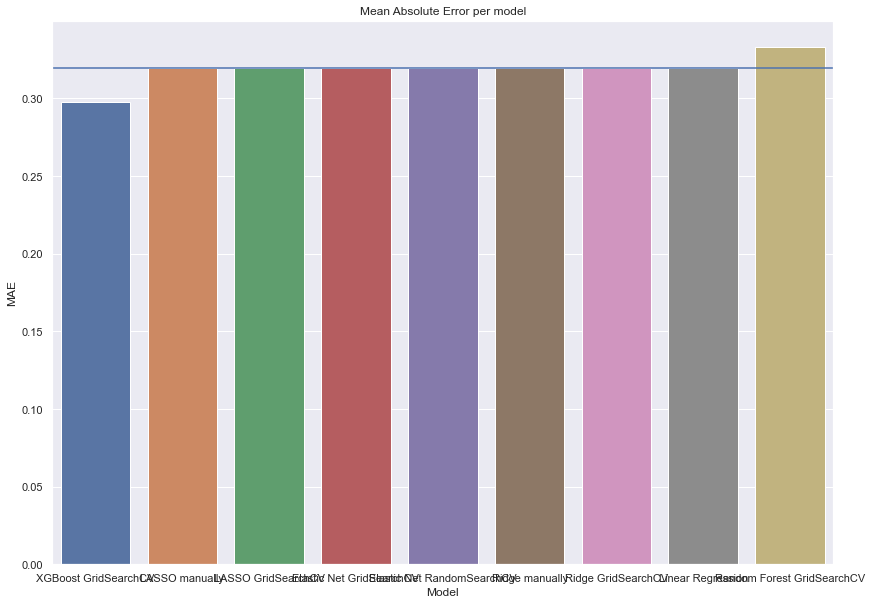

In [100]:
display_barplot_errors(results, baseline_model="Linear Regression", title="Mean Absolute Error per model", metric="MAE")

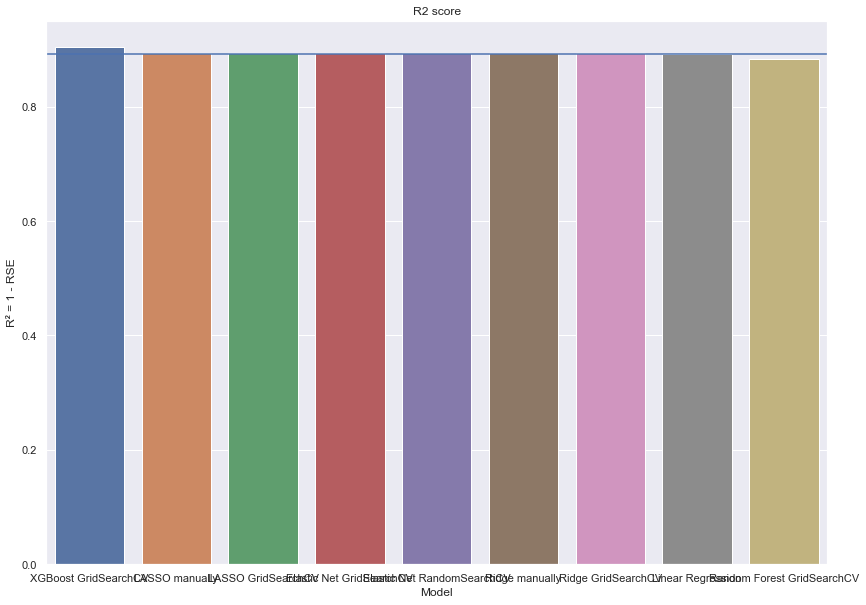

In [101]:
display_barplot_errors(results, baseline_model="Linear Regression", title="R2 score", metric="R² = 1 - RSE")

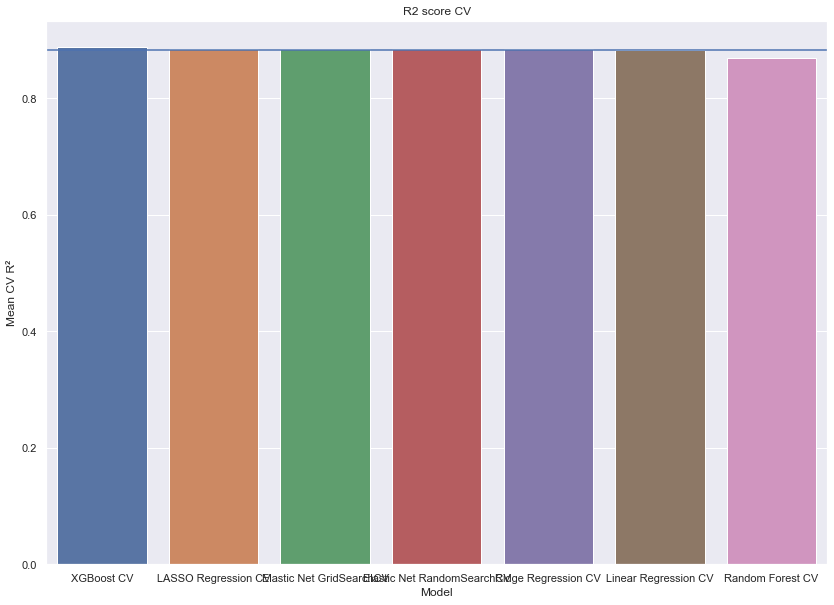

In [102]:
display_barplot_errors(results_cv, baseline_model="Linear Regression CV", title="R2 score CV", metric="Mean CV R²")

In [103]:
t1 = time()
print("computing time : {:8.6f} sec".format(t1-t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1-t0)))

computing time : 375.252883 sec
computing time : 00:06:15


##### We choose the best regressor

In [104]:
best_model = XGBoost_grid.best_estimator_

In [105]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [106]:
dict_models = {
    'Ridge': Ridge_grid.best_estimator_,
    'Lasso': Lasso_grid.best_estimator_,
    'Elastic_Net': Elastic_GridSearch_grid.best_estimator_,
    'Random_Forest_Regressor': RandomForest_grid.best_estimator_,
    'XGBoost': XGBoost_grid.best_estimator_,
    'best_model_{}'.format(target_dir): best_model
}

In [107]:
for name, model in dict_models.items():
    filename = 'model/test/' + '{}/model/'.format(target_dir) + name + '.sav'
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

#### We load the models saved locally and check their prediction time

['best_model_ratio.sav', 'Elastic_Net.sav', 'Lasso.sav', 'Random_Forest_Regressor.sav', 'Ridge.sav', 'XGBoost.sav']
_____Prediction time for : best_model_ratio_____
Prediction time : 0.000000 sec
_____Prediction time for : Elastic_Net_____
Prediction time : 0.015579 sec
_____Prediction time for : Lasso_____
Prediction time : 0.000000 sec
_____Prediction time for : Random_Forest_Regressor_____
Prediction time : 0.124998 sec
_____Prediction time for : Ridge_____
Prediction time : 0.000000 sec
_____Prediction time for : XGBoost_____
Prediction time : 0.000000 sec


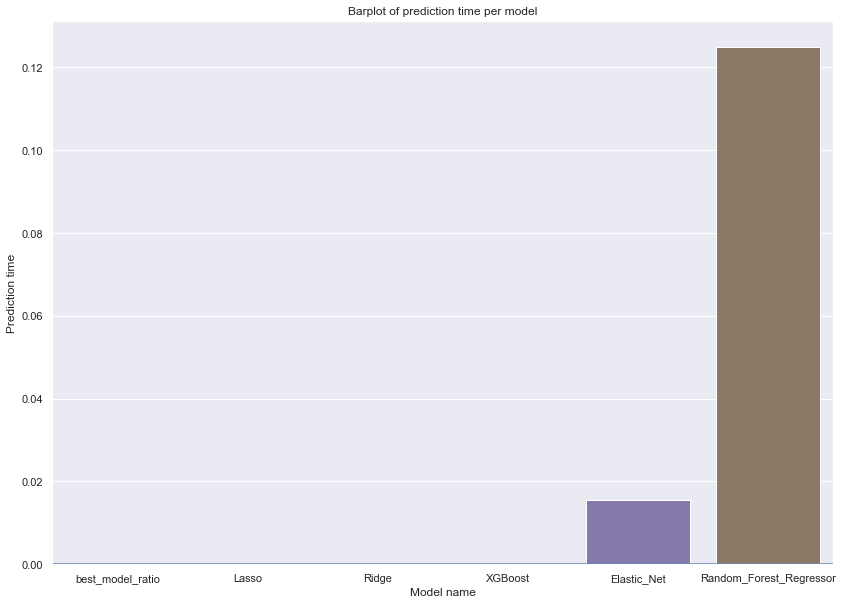

In [108]:
path_model = 'model/test/' + '{}/model'.format(target_dir)
all_models = [f for f in listdir(path_model) if isfile(join(path_model, f))]
print(all_models)

# load the model from disk
for model_name in all_models:
    filename = 'model/test/' + '{}/model/'.format(target_dir) + model_name
    loaded_model = pickle.load(open(filename, 'rb'))
    print("_____Prediction time for :", model_name[:-4] + "_____")
    prediction_time = compute_prediction_time(loaded_model, model_name[:-4], X_test, prediction_time) # [:-3] removed .sav

display_barplot_prediction_time(prediction_time)

#### Predicting CO2 using predicted energy